In [92]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('bmh')
import numpy as np
import sympy
import sys  #Use this to abort if the condition is not right.
from time import time

In [93]:
sympy.init_printing()

z = sympy.symbols('z')
H=25.0
K0=1e-6
K1=1e-4
turncation=H/2
scale=1.0

#sym_Diffu = K0+(K1-K0)*(1-1/(1+sympy.exp(-(turncation-z)/scale)))
sym_Diffu = K0+(K1-K0)/(scale*sympy.exp(z-turncation)+1)
sym_dKdz  = sympy.diff(sym_Diffu, z, 1)
sym_d2Kdz2 =  sympy.diff(sym_Diffu, z, 2)
sym_d3Kdz3 =  sympy.diff(sym_Diffu, z, 3)

Diffu  =  sympy.utilities.lambdify(z,sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,sym_dKdz,np)
d2Kdz =  sympy.utilities.lambdify(z,sym_d2Kdz2,np)
d3Kdz = sympy.utilities.lambdify(z,sym_d3Kdz3,np)

del z #delete the symbol


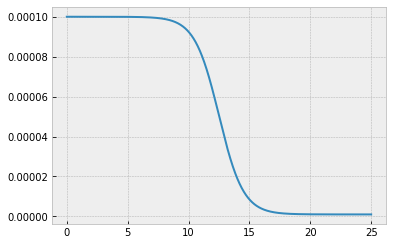

In [94]:
Lz=np.linspace(0,H,1000)
plt.plot(Lz, Diffu(Lz))

In [95]:
#%% Functions

def Gaussian(z, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-((z-mu)/sigma)**2/2)

def OneTimeStep(C, K, dKdz, dt, dz):
    dC=np.empty(C.shape[0]+2, dtype=float)
     #We need two extra ghost points at the start and the end.   
    NyC=np.empty(C.shape[0]+2, dtype=float)
    NyC[1:-1]=C.copy()
    NyC[0]=C[1]
    NyC[-1]=C[-2]
    
    dC=dKdz*(NyC[2:]-NyC[0:-2])/(2*dz)+K*(NyC[2:]-2*NyC[1:-1]+NyC[0:-2])/(dz**2)
            
    dC=dt*dC;
    C=C+dC
    return C


def step_m2(z,H,dt,N_sample,w=0):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=d2Kdz(z)
    dddkdz=d3Kdz(z)
    sqrt2k=np.sqrt(2*k)
    
    a= w + dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
            
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e(z,H,dt,N_sample,w=0):
    dW=np.random.normal(0,np.sqrt(dt),N_sample) 
    
    a=w+dKdz(z)
    b=np.sqrt(2*Diffu(z))
    temp=z+a*dt+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_m(z,H,dt,N_sample,dW=None,w=0):
    if dW is None:
        dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    sqrt2k=np.sqrt(2*k)
    
    a= w + dkdz
    b= sqrt2k 
    db=dkdz/b
    #temp= z + w*dt + (1/2)*dkdz*(dW*dW+dt) + b*dW
    temp= z+ a*dt+1/2*(b*db)*(dW*dW-dt)+b*dW
    
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_v(z,H,dt,N_sample,dW=None,w=0):
    if dW is None:
        dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=w+dKdz(z)
    b=np.sqrt(2*Diffu(z + 1/2*a*dt))
    temp= z + a*dt + b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp    
#%% Functions

def Lagrangian(H=None, dtLa=None, T=None, Np=None, mu=None, sigma=None):
    if (H or dtLa or T or Np or mu or sigma) == None:
        print("Using default values")
        H=25.0
        dtLa=1200  
        T=0.5*3600 
        Np=2000000             

    Nt=int(T/dtLa)
    
    if (T%dtLa) != 0:
        print("Tmax is not dividable to dtLa")
        sys.exit(0)

    LaM2=np.random.normal(mu, sigma, Np)
    LaM1=LaM2.copy()
    LaVi=LaM2.copy()
    LaEM=LaM2.copy()
    
    start=time()
    print("---Lagrangian part---")
    print("Number of time step: ", Nt)
    print("Number of particles: ", Np)
    print("dt of Lagrangian: ", dtLa)
    for i in range(Nt):
        print("\r","Working: ", i, " of ", Nt, end="\r", flush=True)       
        LaM2=step_m2(LaM2,H,dtLa,Np)
        LaEM=step_e(LaEM,H,dtLa,Np)
        LaVi=step_v(LaVi,H,dtLa,Np)
        LaM1=step_m(LaM1,H,dtLa,Np)

    """
    1. Calculate the "$order" momentum of Eulerian.
    2. Calculate the "$order" momentum of Lagrangian.
    """
    order=1
    momLagM2=np.sum(LaM2**order)/LaM2.size
    momLagEM=np.sum(LaEM**order)/LaEM.size
    momLagVi=np.sum(LaVi**order)/LaVi.size
    momLagM1=np.sum(LaM1**order)/LaM1.size
    
    print("Order: ", order)
    print("Done! Time used: ", time()-start)
    return momLagM2,momLagEM,momLagVi,momLagM1

def Eulerain(dz=None, H=None, dtEu=None, T=None, mu=None, sigma=None):
    if (dz or H or dtEu or T) is None:
        print ("Using default value")
        dz=0.04
        H=25.0
        dtEu=0.1        
        T=12*3600 
        
    Nt=int(T/dtEu) 
    Nz=int(H/dz)
    zEu=np.linspace(0,H,Nz)    
    Conc=Gaussian(zEu,mu,sigma) 
    K_array=Diffu(zEu)
    dKdz_arry=dKdz(zEu)
        
    for i in range(Nt):
        Conc=OneTimeStep(Conc, K_array, dKdz_arry, dtEu, dz)
        if (i % int(Nt/100) ==0): #Just for printing
            print("\r", float(i*100/Nt+1),"%", end="\r",flush=True)
    print("\n")
    
#    plt.plot(zEu,Conc,".")
#    plt.show()
    order=1
    momConc=np.sum(Conc*zEu**order)*dz
    np.save("Concentration", Conc)
    return momConc

def Lagrangian_test(H=None, dtLa=None, T=None, Np=None, mu=None, sigma=None):
    if (H or dtLa or T or Np or mu or sigma) == None:
        print("Using default values")
        H=25.0
        dtLa=1200  
        T=0.5*3600 
        Np=2000000             

    Nt=int(T/dtLa)
    
    if (T%dtLa) != 0:
        print("Tmax is not dividable to dtLa")
        sys.exit(0)

    LaM2=np.random.normal(mu, sigma, Np)
    LaM1=LaM2.copy()
    LaVi=LaM2.copy()
    LaEM=LaM2.copy()
    
    start=time()
    print("---Lagrangian part---")
    print("Number of time step: ", Nt)
    print("Number of particles: ", Np)
    print("dt of Lagrangian: ", dtLa)
    for i in range(Nt):
        print("\r","Working: ", i +1, " of ", Nt, end="\r", flush=True)       
        LaM2=step_m2(LaM2,H,dtLa,Np)
        LaEM=step_e(LaEM,H,dtLa,Np)
        LaVi=step_v(LaVi,H,dtLa,Np)
        LaM1=step_m(LaM1,H,dtLa,Np)
    print()
    print("Done! Time used: ", time()-start)
    return LaM2, LaEM, LaVi, LaM1


def Eulerian_test(dz=None, H=None, dtEu=None, T=None, mu=None, sigma=None):
    if (dz or H or dtEu or T) is None:
        print ("Using default value")
        dz=0.04
        H=25.0
        dtEu=0.1        
        T=12*3600 
        
    Nt=int(T/dtEu) 
    Nz=int(H/dz)
    zEu=np.linspace(0,H,Nz)    
    Conc=Gaussian(zEu,mu,sigma) 
    K_array=Diffu(zEu)
    dKdz_arry=dKdz(zEu)
        
    for i in range(Nt):
        Conc=OneTimeStep(Conc, K_array, dKdz_arry, dtEu, dz)
        if (i % int(Nt/100) ==0): #Just for printing
            print("\r", float(i*100/Nt+1),"%", end="\r",flush=True)
    print("\n")
    
#    plt.plot(zEu,Conc,".")
#    plt.show()
#    order=1
 #   momConc=np.sum(Conc*zEu**order)*dz
  #  np.save("Concentration", Conc)
    return Conc



In [90]:
#input parameters.
dz=0.1
dtEu=0.1
T=12*3600               #12 hours
Np=20000000              #Number of particles
mu=12.5
sigma=1.0

Con=Eulerain_test(dz, H, dtEu, T, mu, sigma)



 100.0 %.0 % 15.0 % 20.0 % 25.0 % 34.0 % 38.0 % 43.0 % 61.0 % 71.0 % 73.0 % 83.0 %



In [91]:
M2, EM, Vi, M1=Lagrangian_test(H, 400, T, Np, mu, sigma)

---Lagrangian part---
Number of time step:  108
Number of particles:  20000000
dt of Lagrangian:  400
 Working:  108  of  108
Done! Time used:  998.0644965171814


104973.09143401719 



<Figure size 576x360 with 0 Axes>

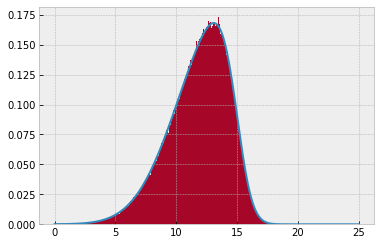

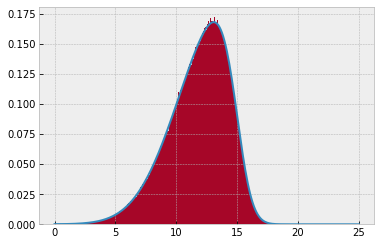

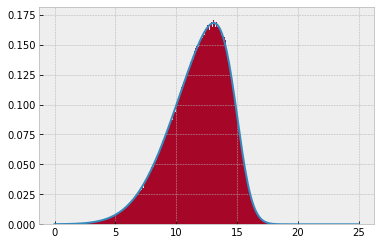

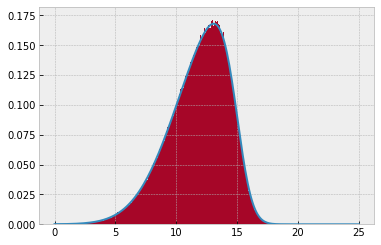

In [82]:
z=np.linspace(0,25, 2000)
D=np.amin(np.abs(1/d2Kdz(z)))
print(D, "\n")

fig=plt.figure(1, figsize=(8,5))
fig, ax = plt.subplots(1)
z=np.linspace(0, 25, Con.size)
plt.plot(z,Con)
n, bins, patches=ax.hist(M2, 1000, density=1)

fig=plt.figure(2, figsize=(8,5))
fig, ax = plt.subplots(1)
z=np.linspace(0, 25, Con.size)
plt.plot(z,Con)
n, bins, patches=ax.hist(EM, 1000, density=1)

fig=plt.figure(3, figsize=(8,5))
fig, ax = plt.subplots(1)
z=np.linspace(0, 25, Con.size)
plt.plot(z,Con)
n, bins, patches=ax.hist(Vi, 1000, density=1)

fig=plt.figure(4, figsize=(8,5))
fig, ax = plt.subplots(1)
z=np.linspace(0, 25, Con.size)
plt.plot(z,Con)
n, bins, patches=ax.hist(M1, 1000, density=1)




In [98]:
#input parameters.
dz=0.005
dtEu=0.001
T=12*3600               #12 hours
Np=2000000              #Number of particles
mu=12.5
sigma=1.0

momConc=Eulerain(dz, H, dtEu, T, mu, sigma)
np.save("monConc",momConc)
print(momConc)

KeyboardInterrupt: 

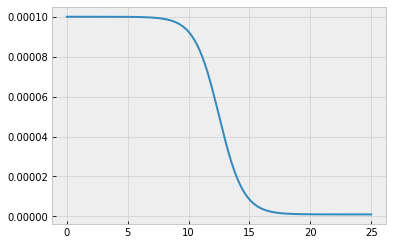

104973.09143401719 

---Lagrangian part---
Number of time step:  216
Number of particles:  2000000
dt of Lagrangian:  200
Order:  1  215  of  216
Done! Time used:  187.3269579410553
weak_conM2 [0.00363413 0.         0.         0.         0.         0.
 0.         0.         0.        ]
weak_conEM [0.00280455 0.         0.         0.         0.         0.
 0.         0.         0.        ]
weak_conM1 [0.00205756 0.         0.         0.         0.         0.
 0.         0.         0.        ]
weak_conVi [0.00122326 0.         0.         0.         0.         0.
 0.         0.         0.        ]

---Lagrangian part---
Number of time step:  108
Number of particles:  2000000
dt of Lagrangian:  400
Order:  1  107  of  108
Done! Time used:  91.28387665748596
weak_conM2 [0.00363413 0.00337301 0.         0.         0.         0.
 0.         0.         0.        ]
weak_conEM [0.00280455 0.00522635 0.         0.         0.         0.
 0.         0.         0.        ]
weak_conM1 [0.00205756 0.0

In [99]:
#Part 2 Calculate weak convergence

z=np.linspace(0,25, 500)
D=Diffu(z)
plt.plot(z,D,"-")
plt.show()
z=np.linspace(0,25, 2000)
D=np.amin(np.abs(1/d2Kdz(z)))
print(D, "\n")

#input parameters.
dz=0.005
dtEu=0.001
T=12*3600               #12 hours
Np=2000000              #Number of particles
mu=12.5
sigma=1.0

Nt=int(T/dtEu) 
Nz=int(H/dz)

#dtLa_array=np.array([100, 200, 400, 600, 800, 1200, 1600, 1800, 2400, 2700])

dtLa_array=np.array([200, 400, 600, 800, 1200, 1600, 1800, 2400, 2700])

#dtLa_array=np.array([600,900,1200, 1800, 2700, 3600, 5400, 7200, 10800, 14400, 21600])

weak_conM2=np.zeros(dtLa_array.size)
weak_conEM=np.zeros(dtLa_array.size)
weak_conVi=np.zeros(dtLa_array.size)
weak_conM1=np.zeros(dtLa_array.size)

momLagM2=np.zeros(dtLa_array.size)
momLagEM=np.zeros(dtLa_array.size)
momLagM1=np.zeros(dtLa_array.size)
momLagVi=np.zeros(dtLa_array.size)

for i in range(dtLa_array.size):
    momLagM2[i],momLagEM[i],momLagVi[i],momLagM1[i]=Lagrangian(H, dtLa_array[i], T, Np, mu, sigma)
    weak_conM2[i]=np.abs(momLagM2[i]-momConc)
    weak_conEM[i]=np.abs(momLagEM[i]-momConc)
    weak_conVi[i]=np.abs(momLagVi[i]-momConc)
    weak_conM1[i]=np.abs(momLagM1[i]-momConc)
    print("weak_conM2", weak_conM2)
    print("weak_conEM", weak_conEM)
    print("weak_conM1", weak_conM1)
    print("weak_conVi", weak_conVi)
    print("")
    
np.save("Weak_EM",weak_conEM)
np.save("Weak_M2",weak_conM2)
np.save("Weak_Vi",weak_conVi)
np.save("Weak_M1",weak_conM1)
np.save("dtArray",dtLa_array)


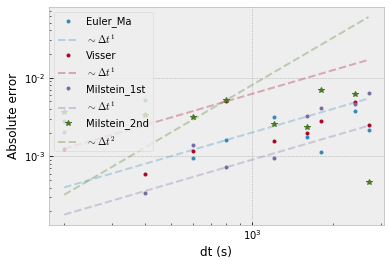

In [100]:
weak_conEM=np.load("Weak_EM.npy")
weak_conM2=np.load("Weak_M2.npy")
weak_conVi=np.load("Weak_Vi.npy")
weak_conM1=np.load("Weak_M1.npy")
dtLa_array=np.load("dtArray.npy")

i = 3
fig=plt.figure(1)
l, = plt.plot(dtLa_array, weak_conEM,".",label = "Euler_Ma")
plt.plot(dtLa_array, (weak_conEM[i]/dtLa_array[i]**1) * dtLa_array**1, "--",
         c = l.get_color(), label = "$\sim \Delta t^1$", alpha=0.3)

l, = plt.plot(dtLa_array, weak_conVi,".",label = "Visser")
plt.plot(dtLa_array, (weak_conVi[i]/dtLa_array[i]**1) * dtLa_array**1, "--",
         c = l.get_color(), label = "$\sim \Delta t^1$", alpha=0.3)

l, = plt.plot(dtLa_array, weak_conM1,".",label = "Milstein_1st")
plt.plot(dtLa_array, (weak_conM1[i]/dtLa_array[i]**1) * dtLa_array**1, "--",
         c = l.get_color(), label = "$\sim \Delta t^1$", alpha=0.3)

l, = plt.plot(dtLa_array, weak_conM2,"*",label = "Milstein_2nd")
plt.plot(dtLa_array, (weak_conM2[i]/dtLa_array[i]**2) * dtLa_array**2, "--", 
         c = l.get_color(), label = "$\sim \Delta t^2$", alpha=0.3)

plt.xlabel('dt (s)')
plt.ylabel('Absolute error')
plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.axis('equal')
plt.savefig("figure")